In [20]:
#https://medium.com/@curiousily/making-a-predictive-keyboard-using-recurrent-neural-networks-tensorflow-for-hackers-part-v-3f238d824218
# note: I trained on alice in wonderland, about 1/4 the length of his Nietzsche data set.
# I also tested with "seeds" that come from his Nietzsche examples!
# TODO 
#    - what happens if you let it run further by itself? 
#   - Use  GRU instead of LSTM

import numpy as np
np.random.seed(42)
import tensorflow as tf
tf.set_random_seed(42)
from keras.models import Sequential, load_model
from keras.layers import Dense, Activation
from keras.layers import LSTM, GRU, Dropout,BatchNormalization
from keras.layers import TimeDistributed
from keras.layers.core import Dense, Activation, Dropout, RepeatVector
from keras.optimizers import RMSprop
from keras import regularizers
import matplotlib.pyplot as plt
import pickle
import sys
import os

from keras.callbacks import ModelCheckpoint

import heapq
import seaborn as sns
from pylab import rcParams


%matplotlib inline
sns.set(style='whitegrid', palette='muted', font_scale=1.5)
rcParams['figure.figsize'] = 12, 5

In [21]:
trainP=True
useNietzsche=True
useCarroll=True

#FILENAME="carroll.3.20"   #for writing or reading
#FILENAME="nietzsche.3.20"   #for writing or reading
LOGDIR="LOG"
FILENAME=LOGDIR + "/foobar"

if not os.path.exists(LOGDIR):
    os.makedirs(LOGDIR)

SEQUENCE_LENGTH = 40
EPOCHS=1
step = 3   #skip this number of chars for generating new training sequences
layer1size=128
topN=1
topNStartWord=3
k_phraseLength=100

k_condNietzsche=[0,0]
k_condCarroll=[0,0]

In [22]:
import re as re
def cleanText(text) :
    # replace all numbers followed by an optional letter and then a dot (eg numbered paragraphs)                                    
    text = re.sub("(^|\W)\d+[a-zA-Z]*($|\W|\.)", "", text)
    #escaped apotrophes                                                                                                             
    text = text.replace('\n', ' ').replace("\'", "'").replace("\"","").replace('[Illustration]',"").replace('*',"")
    #repeated white space
    text=re.sub('\s{2,}',' ', text)
    text=re.sub('â', 'a', text)
    text=re.sub('æ', 'a', text)
    text=re.sub('è', 'e', text)
    text=re.sub('ï', 'i', text)
    text=re.sub('ù', 'u', text)
    text=re.sub('&c', 'etc', text)
    text=re.sub('\ufeff', '', text)
    text=re.sub('‘', "'", text)
    text=re.sub('’', "'", text)
    text=re.sub('“', "'", text)
    text=re.sub('”', "'", text)

    # try to normalize Carroll text a bit more, although there are still way more contractions in carrll than nietzsche             
    text=re.sub('!', " ", text)
    text=re.sub('\?', " ", text)
#                                                                                                                                   
    text=re.sub('--', " ", text)
    text=re.sub('_', " ", text)

    #repeated white space                                                                                                           
    text=re.sub('\s{2,}',' ', text)

    return text

text1=""
text2=""

if useNietzsche :
    path = 'nietzsche.txt'
    text1 = cleanText(open(path, 'r', encoding='utf-8').read().lower())
    print('corpus 1 length:', len(text1))
    print("NIETZXCHE CHARS: ", sorted(list(set(text1))))
    
if useCarroll :
    path = 'carroll.txt'
    text2 = cleanText(open(path, 'r', encoding='utf-8').read().lower())
    print('corpus 2 length:', len(text2))
    print("CARROLL CHARS: ", sorted(list(set(text2))))

text=text1+text2
print('total cleaned corpus length is ', len(text))

chars = sorted(list(set(text)))
char_indices = dict((c, i) for i, c in enumerate(chars))
indices_char = dict((i, c) for i, c in enumerate(chars))

lenchars=len(chars)
lenconditional=2
lenAugmentedInput=lenchars+lenconditional

print(f'unique chars: {len(chars)}')
#chars
#indices_char
#text

corpus 1 length: 372028
NIETZXCHE CHARS:  [' ', "'", '(', ')', ',', '-', '.', '5', ':', ';', '[', ']', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']
corpus 2 length: 331969
CARROLL CHARS:  [' ', "'", '(', ')', ',', '-', '.', '0', '1', '3', ':', ';', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']
total cleaned corpus length is  703997
unique chars: 41


In [23]:
text1

" supposing that truth is a woman what then is there not ground for suspecting that all philosophers, in so far as they have been dogmatists, have failed to understand women that the terrible seriousness and clumsy importunity with which they have usually paid their addresses to truth, have been unskilled and unseemly methods for winning a woman certainly she has never allowed herself to be won; and at present every kind of dogma stands with sad and discouraged mien if, indeed, it stands at all for there are scoffers who maintain that it has fallen, that all dogma lies on the ground nay more, that it is at its last gasp. but to speak seriously, there are good grounds for hoping that all dogmatizing in philosophy, whatever solemn, whatever conclusive and decided airs it has assumed, may have been only a noble puerilism and tyronism; and probably the time is at hand when it will be once and again understood what has actually sufficed for the basis of such imposing and absolute philosophi

In [24]:
text2

"alice was beginning to get very tired of sitting by her sister on the bank, and of having nothing to do: once or twice she had peeped into the book her sister was reading, but it had no pictures or conversations in it, and where is the use of a book, thought alice, without pictures or conversations so she was considering in her own mind, (as well as she could, for the hot day made her feel very sleepy and stupid,) whether the pleasure of making a daisy-chain was worth the trouble of getting up and picking the daisies, when a white rabbit with pink eyes ran close by her. there was nothing very remarkable in that, nor did alice think it so very much out of the way to hear the rabbit say to itself dear, dear i shall be too late (when she thought it over afterwards, it occurred to her that she ought to have wondered at this, but at the time it all quite natural); but when the rabbit actually took a watch out of its waistcoat-pocket, looked at it, and then hurried on, alice started to her 

In [25]:
#CREAT TRAINING DATA
# cut the corpus into chunks of 40 characters, spacing the sequences by 3 characters
# Additionally, we will store the next character (the one we need to predict) for every sequence

sentences = []
next_chars = []
cond_input=[]

if useNietzsche :
    for i in range(0, len(text1) - SEQUENCE_LENGTH, step):
        sentences.append(text1[i: i + SEQUENCE_LENGTH])
        next_chars.append(text1[i + SEQUENCE_LENGTH])
        cond_input.append(k_condNietzsche)

if useCarroll :
    for j in range(0, len(text2) - SEQUENCE_LENGTH, step):
        sentences.append(text2[j: j + SEQUENCE_LENGTH])
        next_chars.append(text2[j + SEQUENCE_LENGTH])
        cond_input.append(k_condCarroll)

print(f'num training examples: {len(sentences)}')

num training examples: 234639


In [26]:
# generate features and labels - one-host versions of the input and prediction vectors

X = np.zeros((len(sentences), SEQUENCE_LENGTH, lenAugmentedInput), dtype=np.bool)  #x[sample_index][one-hot array]
y = np.zeros((len(sentences), lenchars), dtype=np.bool)
for i, sentence in enumerate(sentences):
    for t, char in enumerate(sentence):
        X[i, t, char_indices[char]] = 1
        X[i, t,-lenconditional:] = cond_input[i] # set conditional bit on last charcter in each training sample
    y[i, char_indices[next_chars[i]]] = 1

In [27]:

print("len of first input vector, first character vector x is ", str(len(X[0][0])))
print("a character in a sentice is ", X[141000][0] )


len of first input vector, first character vector x is  43
a character in a sentice is  [ True False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False]


In [28]:
print(str(X.shape))   #training_samples, SEQUENCE_LENGTH, lenAugmentedInput

(234639, 40, 43)


In [29]:
#LST layer with 128 neurons
# takes a shape which is 
model = Sequential()
model.add(LSTM(layer1size,  input_shape=(SEQUENCE_LENGTH, lenAugmentedInput)))

#FAIL model.add(LSTM(layer1size, dropout=0.25, recurrent_dropout=0.25, input_shape=(SEQUENCE_LENGTH, lenAugmentedInput)))
#FAIL model.add(GRU(layer1size,  input_shape=(SEQUENCE_LENGTH, lenAugmentedInput), kernel_regularizer=regularizers.l2(0.1), recurrent_regularizer=regularizers.l2(0.1), bias_regularizer=regularizers.l2(0.1), activity_regularizer=regularizers.l2(0.1)))

#model.add(Dense(lenchars, kernel_regularizer=regularizers.l2(0.1),  bias_regularizer=regularizers.l2(0.1), activity_regularizer=regularizers.l2(0.1)))
#model.add(Dense(lenchars, kernel_regularizer=regularizers.l2(0.1),  bias_regularizer=regularizers.l2(0.1), activity_regularizer=regularizers.l2(0.1)))
model.add(BatchNormalization())
#model.add(Dropout(0.5))
model.add(Dense(lenchars))

model.add(Activation('softmax'))

In [30]:
FILENAME + '.history.p'

'LOG/foobar.history.p'

In [31]:
# Train. Validate with 5% of the examples


if trainP :
    optimizer = RMSprop(lr=0.01)
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    
    # checkpoint
    filepath= FILENAME + ".cp-{epoch:02d}-{val_acc:.2f}.hdf5"
    checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1)
    callbacks_list = [checkpoint]


    history = model.fit(X, y, validation_split=0.1, batch_size=128, epochs=EPOCHS, shuffle=True, callbacks=callbacks_list).history

    #Save (How does this work ??)
    model.save(FILENAME + '.keras_model.h5')
    pickle.dump(history, open(FILENAME + 'history.p', 'wb'))


Train on 211175 samples, validate on 23464 samples
Epoch 1/1
211175/211175 [==============================] - 336s - loss: 1.9888 - acc: 0.4084 - val_loss: 1.9102 - val_acc: 0.4241


In [32]:

# check to make sure the save worked
model = load_model(FILENAME + '.keras_model.h5')
history = pickle.load(open(FILENAME + 'history.p', "rb"))

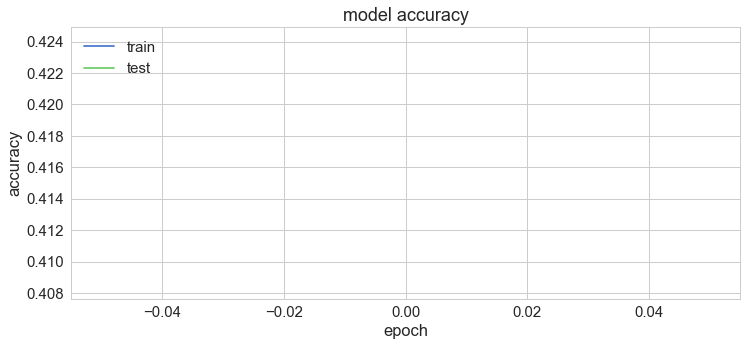

In [33]:
plt.plot(history['acc'])
plt.plot(history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left');

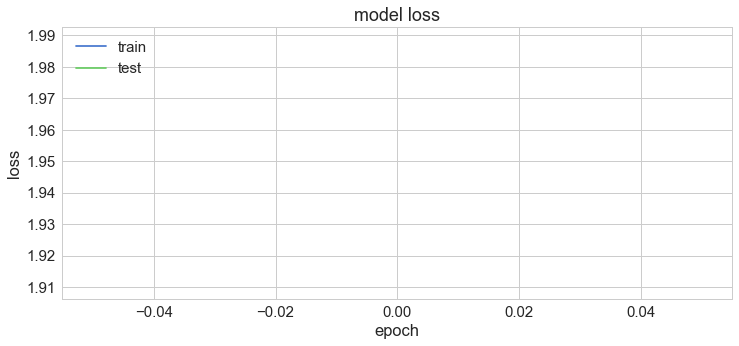

In [34]:
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left');

In [35]:
# create one-hot represetntation of input (will be padded with 0 vectors if text < SEQUENCE_LENGTH chars)
def prepare_input_old(text):
    print("will prepare: ", text)
    x = np.zeros((1, SEQUENCE_LENGTH, len(chars)))  

    for t, char in enumerate(text):
        x[0, t, char_indices[char]] = 1.
        
    return x

In [36]:
# changes "oldest" element in buffer to new element, then rolls the circular buffer 
def shift(c,condval,buf) :
    buf[0,0].fill(0)
    buf[0,0,char_indices[c]]=1
    buf[0,0,-lenconditional:]=condval
    buf[0]=np.roll(buf[0],-1, 0)
    return buf
    
# create one-hot represetntation of input (will be padded with 0 vectors if text < SEQUENCE_LENGTH chars)
def prepare_input(text,condval):
    print("will prepare: ", text)
    x = np.zeros((1, SEQUENCE_LENGTH, lenAugmentedInput))  
    for t, char in enumerate(text):
        shift(char, condval, x)      
    return x

In [37]:
# preds is an array of scores greater than 0 for each letter
# sample(preds) return the indexes of the n highest
#
# NOTE: If you aren't going to throw the dice, why not just take the 3 largest in the preds array directly?
#
def sample(preds, top_n=3):
    preds = np.asarray(preds).astype('float64')
    preds = np.log(preds)
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    #print('preds are ', preds)
    
    return heapq.nlargest(top_n, range(len(preds)), preds.take) # 3rd arg is a 1-arg function used as key for sorting

In [38]:
# preds is an array of scores unnormalized scores (logits)
# rsample(preds) Selects top_n, then throws dice to choose them in a randomized order based on their relative prob.

def rsample(preds, top_n=3, verbose=0):
    preds = np.asarray(preds).astype('float64')
    
    exp_preds = np.exp(preds)
    #sm=np.sum(exp_preds)
    preds = exp_preds / exp_preds.sum(0)
    
    # indexes of largest vals in preds, orders large to small
    idx = heapq.nlargest(top_n, range(len(preds)), preds.take)
    # and their values
    vals = np.take(preds, idx )
    #normalized (for np.random.choice)
    vals=vals/vals.sum(0)
    
    if (verbose == 1) :
        print("probability vals are ", vals)
    your_samples = np.random.choice(idx, size=top_n, replace=False,p=vals)
    return your_samples


In [39]:
# test sampling the probablity distribution
bar=[2,2,3,4,5,6]
rs = rsample(bar, top_n=3, verbose=1)
print("rsample: ", rs)
print("sample: ", sample(bar))
count=np.zeros(len(bar))
for i in range(10000) :
    foo=rsample(bar, top_n=topN)
    #foo=sample(bar, top_n=topN)
    #print("foo = ", foo)
    for j in range(len(bar)) :
        if j == foo[0] :
            count[j]=count[j]+1

for j in range(len(bar)) :
    print(" count ", str(j), " = ", str(count[j]))
    

probability vals are  [ 0.66524096  0.24472847  0.09003057]
rsample:  [5 3 4]
sample:  [5, 4, 3]
 count  0  =  0.0
 count  1  =  0.0
 count  2  =  0.0
 count  3  =  0.0
 count  4  =  0.0
 count  5  =  10000.0


In [40]:
def predict_completion_old(text):
    print("predict_completion for: ", text)
    original_text = text
    generated = text
    completion = ''
    while True:
        x = prepare_input(text)
        preds = model.predict(x, verbose=0)[0]
        next_index = rsample(preds, top_n=topN)[0] # SAMPLE
        next_char = indices_char[next_index]
        text = text[1:] + next_char
        completion += next_char
        
        print("len is ", len(original_text + completion))
        if (len(original_text + completion) + 2 > len(original_text) and next_char == ' ') or (len(original_text + completion) > 100) : 
            return completion

In [41]:
def wordEnd(c) :
    if c in [' ', ';', '.', '!', ',', '?'] : 
        return True
    else :
        return False

def predict_completion(text, condval):
    print("predict_completion for: ", text)
    original_text = text
    generated = text
    completion = ''

    next_char=text[-1]
    
    x = prepare_input(text, condval)
    while True:
        
        preds = model.predict(x, verbose=0)[0]
        
        if (wordEnd(next_char)) : #if we are about to start a new word
            next_index = rsample(preds, top_n=topNStartWord)[0] # SAMPLE
        else :
            #can add a little more randomness so we don't get stuck in repetitions at the word level
            next_index = rsample(preds, top_n=topN)[0] # SAMPLE
                
        next_char = indices_char[next_index]
        text = text[1:] + next_char
        completion += next_char
        

        if len(original_text + completion) > k_phraseLength : 
            print("Extended text is : ", original_text + completion)
            return completion
        
        #if (len(original_text + completion) + 2 > len(original_text) and next_char == ' ') or (len(original_text + completion) > k_phraseLength100) :
        #    return completion
        
        x=shift(next_char, condval, x)
        

In [42]:
# predict n different completions for the first 40 characters of text.
def predict_completions(text, condval, n=3 ):
    x = prepare_input(text, condval)
    preds = model.predict(x, verbose=0)[0]
    next_indices = rsample(preds, n)  # SAMPLE (for the character folloiwng the input)
    print("Will predict completions for the indices : ", [indices_char[idx] for idx in next_indices])
    return [indices_char[idx] + predict_completion(text[0:] + indices_char[idx], condval) for idx in next_indices]


In [43]:
#quotes = [
#    "It is not a lack of love, but a lack of friendship that makes unhappy marriages.",
#    "That which does not kill us makes us stronger.",
#    "I'm not upset that you lied to me, I'm upset that from now on I can't believe you.",
#    "And those who were seen dancing were thought to be insane by those who could not hear the music.",
#    "It is hard enough to remember my opinions, without also remembering my reasons for them!"
#]
#

#quotes = [
#    "It is not a lack of love, but a lack of friendship that makes unhappy marriages"
#    #"It is not a lack of love, but a lack of friendship that makes un"
#]

quotes = [
    "after you hear the word eleph",
    "friendship that makes unhappy ",
    "That which does not kill us makes us "
]

for q in quotes:
    seq = q[-SEQUENCE_LENGTH:].lower()
    print(seq)
    print("... and the completions are : " , predict_completions(seq, k_condCarroll, 5 ))
    print()

after you hear the word eleph
will prepare:  after you hear the word eleph
Will predict completions for the indices :  ['e', 'a', 'o', 'u', 'i']
predict_completion for:  after you hear the word elephe
will prepare:  after you hear the word elephe
Extended text is :  after you hear the word elepher she was that the that the man of the man of complate and all beace of
predict_completion for:  after you hear the word elepha
will prepare:  after you hear the word elepha
Extended text is :  after you hear the word elephate of the stiments of much and all that the man and and all that the st
predict_completion for:  after you hear the word elepho
will prepare:  after you hear the word elepho
Extended text is :  after you hear the word elephose and that all that the stiments and still that all while that the man
predict_completion for:  after you hear the word elephu
will prepare:  after you hear the word elephu
Extended text is :  after you hear the word elephuse of the stiments and all beac

In [44]:
#quotes = [
#    "It is not a lack of love, but a lack of friendship that makes unhappy marriages.",
#    "That which does not kill us makes us stronger.",
#    "I'm not upset that you lied to me, I'm upset that from now on I can't believe you.",
#    "And those who were seen dancing were thought to be insane by those who could not hear the music.",
#    "It is hard enough to remember my opinions, without also remembering my reasons for them!"
#]
#

#quotes = [
#    "It is not a lack of love, but a lack of friendship that makes unhappy marriages"
#    #"It is not a lack of love, but a lack of friendship that makes un"
#]

quotes = [
    "after you hear the word eleph",
    "friendship that makes unhappy ",
    "That which does not kill us makes us "
]

for q in quotes:
    seq = q[-SEQUENCE_LENGTH:].lower()
    print(seq)
    print("... and the completions are : " , predict_completions(seq, k_condNietzsche, 5 ))
    print()
    

after you hear the word eleph
will prepare:  after you hear the word eleph
Will predict completions for the indices :  ['a', 'o', 'i', 'u', 'e']
predict_completion for:  after you hear the word elepha
will prepare:  after you hear the word elepha
Extended text is :  after you hear the word elephate of complate of profultence of much of the man that all still and tha
predict_completion for:  after you hear the word elepho
will prepare:  after you hear the word elepho
Extended text is :  after you hear the word elephose that all still and still and still of profultence to the stiments an
predict_completion for:  after you hear the word elephi
will prepare:  after you hear the word elephi
Extended text is :  after you hear the word elephing and all beace and all while all that the man of the stiments to the 
predict_completion for:  after you hear the word elephu
will prepare:  after you hear the word elephu
Extended text is :  after you hear the word elephuse of profultence of profultenc